# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from IPython.core.display import Image
from keras.preprocessing.image import ImageDataGenerator

from pathlib import Path
import os

from keras.layers.core import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
#path dove si trova il dataframe hmdb51
path = Path.cwd()
print(path)

c:\Users\giorg\Desktop\deep-learning-video-classification


Testing if cuda is on GPU

In [3]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


# Spatial Data Generation


In [2]:
path = './data/hmdb51'
path_rowframes = './data/hmdb51/rawframes/'
path_annotations = './data/hmdb51/annotations/'

img_height = 224
img_width = 224
batch_size = 128
num_classes = 51

num_frames_desired = 17     #number of frames per clip
type_frame = 'img'          #img / flow_x / flow_y
epochs = 150
# partition = 'train'

In [3]:
resize_and_rescale = tf.keras.Sequential([
  # layers.Resizing(img_height, img_height),
  tf.keras.layers.Rescaling(1./127.5, offset=-1),
  #tf.keras.layers.Resizing(img_height, img_width)
])

resize = tf.keras.Sequential([
  tf.keras.layers.Resizing(img_height, img_width)
])

In [4]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.20, fill_mode = "nearest"),
    # layers.RandomZoom(0.2),
    layers.RandomCrop(img_height,img_width),
    # layers.RandomHeight(0.2),
    # layers.RandomWidth(0.2),
    # layers.Resizing(224,224)
    layers.Resizing(img_height, img_width)
    ])

In [6]:
def sampling(list, num_frames_desired):
    step = len(list) // (num_frames_desired)
    #selected_frames = list(range(0, len(list), step))[:num_frames_desired]
    sampled_list = list[0:len(list):step][:num_frames_desired]
    return(sampled_list)

def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    # image = tf.image.random_flip_left_right(image)
    # image = tf.image.resize(image, [img_height, img_width])
    return image

"""def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.repeat() # repeat determines how many times the samples can be repeated in the given dataset. (def = 0)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds"""
    
def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.cache()
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=tf.data.experimental.AUTOTUNE)
  if shuffle:
    ds = ds.shuffle(1000)
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=tf.data.experimental.AUTOTUNE)
  else: 
    ds = ds.map(lambda x, y: (resize(x), y), 
              num_parallel_calls=tf.data.experimental.AUTOTUNE)
  # Batch all datasets.
  ds = ds.batch(batch_size)
  ds = ds.repeat() # repeat determines how many times the samples can be repeated in the given dataset. (def = 0)
  # Use data augmentation only on the training set.
  #if augment:
  #  ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
  #              num_parallel_calls=tf.data.experimental.AUTOTUNE)
  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

def find_paths(partition, type_frame, num_frames_desired):
    if partition == 'train':
        video_list = pd.read_csv(f'{path_annotations}/hmdb51_train_split_1_rawframes.txt', sep=" ", header=None) #train
        video_list.columns = ["path", "num_frames_tot", "class"]
    elif partition == 'val':
        video_list = pd.read_csv(f'{path_annotations}/hmdb51_val_split_1_rawframes.txt', sep=" ", header=None) #test
        video_list.columns = ["path", "num_frames_tot", "class"]
    else:
        raise Exception("invalid partition")

    #temp_path = video_list.loc[0]['path'] #da togliere!!!

    paths = []
    classes = []
    for index, row in video_list.iterrows(): #da togliere [:1]
        temp_path = row['path']                    #da rimuovere il commentato
        frame_list = os.listdir(os.path.join(f'./{temp_path}'))

        frame_list_type = [i for i in frame_list if i.startswith(f'{type_frame}')]

        filename = sampling(frame_list_type, num_frames_desired)

        paths.extend([os.path.join('.\\', temp_path, file) for file in filename])
        temp = [row['class']] * num_frames_desired
        classes.extend(temp)

    #return(list(zip(paths, classes)))
    return(list(zip(paths, classes)), video_list)

In [7]:
# ------- create train set
filenames, video_list = find_paths(partition='train', type_frame=type_frame, num_frames_desired=num_frames_desired)
video_list[['cose', 'class', 'vid']] = video_list["path"].str.rsplit("\\", n = 2, expand = True)

random.shuffle(filenames)

zipped = [list(t) for t in zip(*filenames)]

filenames = zipped[0]
labels = zipped[1]

filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

labels_ds = tf.data.Dataset.from_tensor_slices(labels)
ds = tf.data.Dataset.zip((images_ds, labels_ds))
# train_ds = configure_for_performance(ds)
train_ds = prepare(ds, shuffle=True, augment=True)

In [8]:
frame_number_train = len(filenames)
print(frame_number_train)

60690


In [9]:
# ------- create val test
filenames, video_list = find_paths(partition='val', type_frame=type_frame, num_frames_desired=num_frames_desired)

random.shuffle(filenames)

zipped = [list(t) for t in zip(*filenames)]

filenames = zipped[0]
labels = zipped[1]

filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
images_ds = filenames_ds.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
ds = tf.data.Dataset.zip((images_ds, labels_ds))
# val_ds = configure_for_performance(ds)
val_ds = prepare(ds)

In [10]:
frame_number_val = len(filenames)
print(frame_number_val)

26010


In [11]:
step_per_epoch_train = frame_number_train // batch_size
step_per_epoch_val = frame_number_val // batch_size
print(step_per_epoch_train)
print(step_per_epoch_val)

474
203


# Spatial Stream Model

In [12]:
version = "v4"
arc = "a3"

early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
csv_logger = tf.keras.callbacks.CSVLogger(f'./Models/spatial_stream_CNN/{version}/spatial_model_{version}_{arc}_val_acc_best.csv', append=True)

checkpoint_filepath = f'./Models/spatial_stream_CNN/{version}/spatial_model_{version}_{arc}_val_acc_best.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_sparse_categorical_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
"""
def prep_fn(img):
    img = img / 255.0
    img = (img - 0.5) * 2
    return img

def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    if width >= dy:
        top = int((height - dy) * random.random())
        left = int((width - dx) * random.random())
        right = left + width
        bottom = top + height
    else: 
        top = int((height - dy) * random.random())
        bottom = top + height
        left = 0
        right = width
    img = img[top : bottom, left : right] 
    return img


def crop_generator(batches, crop_length):
    while True:
        batch_x, batch_y = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
        yield (batch_crops, batch_y)

train_image_generator = ImageDataGenerator(
    preprocessing_function=prep_fn,
    horizontal_flip=True,
    rotation_range=20, fill_mode='nearest'
    
) 
"""

In [11]:
"""data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    # layers.RandomZoom(0.2),
    layers.RandomCrop(224,224)
    # layers.RandomHeight(0.2),
    # layers.RandomWidth(0.2),
    # layers.Resizing(224,224)
])"""

In [13]:
num_classes = 51

# model_spat = keras.models.Sequential(tf.keras.layers.Rescaling(1./127.5, offset=-1))
model_spat = keras.models.Sequential()

#data_augmentation

model_spat.add(keras.layers.Conv2D(96, (7,7), strides = 2, input_shape=(224, 224, 3), activation = "relu"))
model_spat.add(keras.layers.BatchNormalization())
model_spat.add(keras.layers.MaxPooling2D((3,3), strides=2, padding="same"))

model_spat.add(keras.layers.ZeroPadding2D(padding = (1,1)))
model_spat.add(keras.layers.Conv2D(256, (5,5), strides = 2, activation='relu'))
model_spat.add(keras.layers.BatchNormalization())
model_spat.add(keras.layers.MaxPooling2D((3,3), strides=2, padding="same"))
          
model_spat.add(keras.layers.ZeroPadding2D(padding = (1,1)))
model_spat.add(keras.layers.Conv2D(512, (3,3), strides = 1, activation='relu'))

model_spat.add(keras.layers.ZeroPadding2D(padding = (1,1)))
model_spat.add(keras.layers.Conv2D(512, (3,3), strides = 1, activation='relu'))

model_spat.add(keras.layers.ZeroPadding2D(padding = (1,1)))
model_spat.add(keras.layers.Conv2D(512, (3,3), strides = 1, activation='relu'))
model_spat.add(keras.layers.MaxPooling2D((3,3), strides=2, padding="same"))

model_spat.add(keras.layers.Flatten())

model_spat.add(keras.layers.Dense(2048, activation='relu'))
model_spat.add(keras.layers.Dropout(0.5))      #valore dropout 0.5 oppure 0.9? paper li usa entrambi 

model_spat.add(keras.layers.Dense(1024, activation='relu'))
model_spat.add(keras.layers.Dropout(0.5))

model_spat.add(keras.layers.Dense(num_classes, activation="softmax"))

In [14]:
model_spat.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 109, 109, 96)      14208     
                                                                 
 batch_normalization (BatchN  (None, 109, 109, 96)     384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 96)       0         
 )                                                               
                                                                 
 zero_padding2d (ZeroPadding  (None, 57, 57, 96)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                      

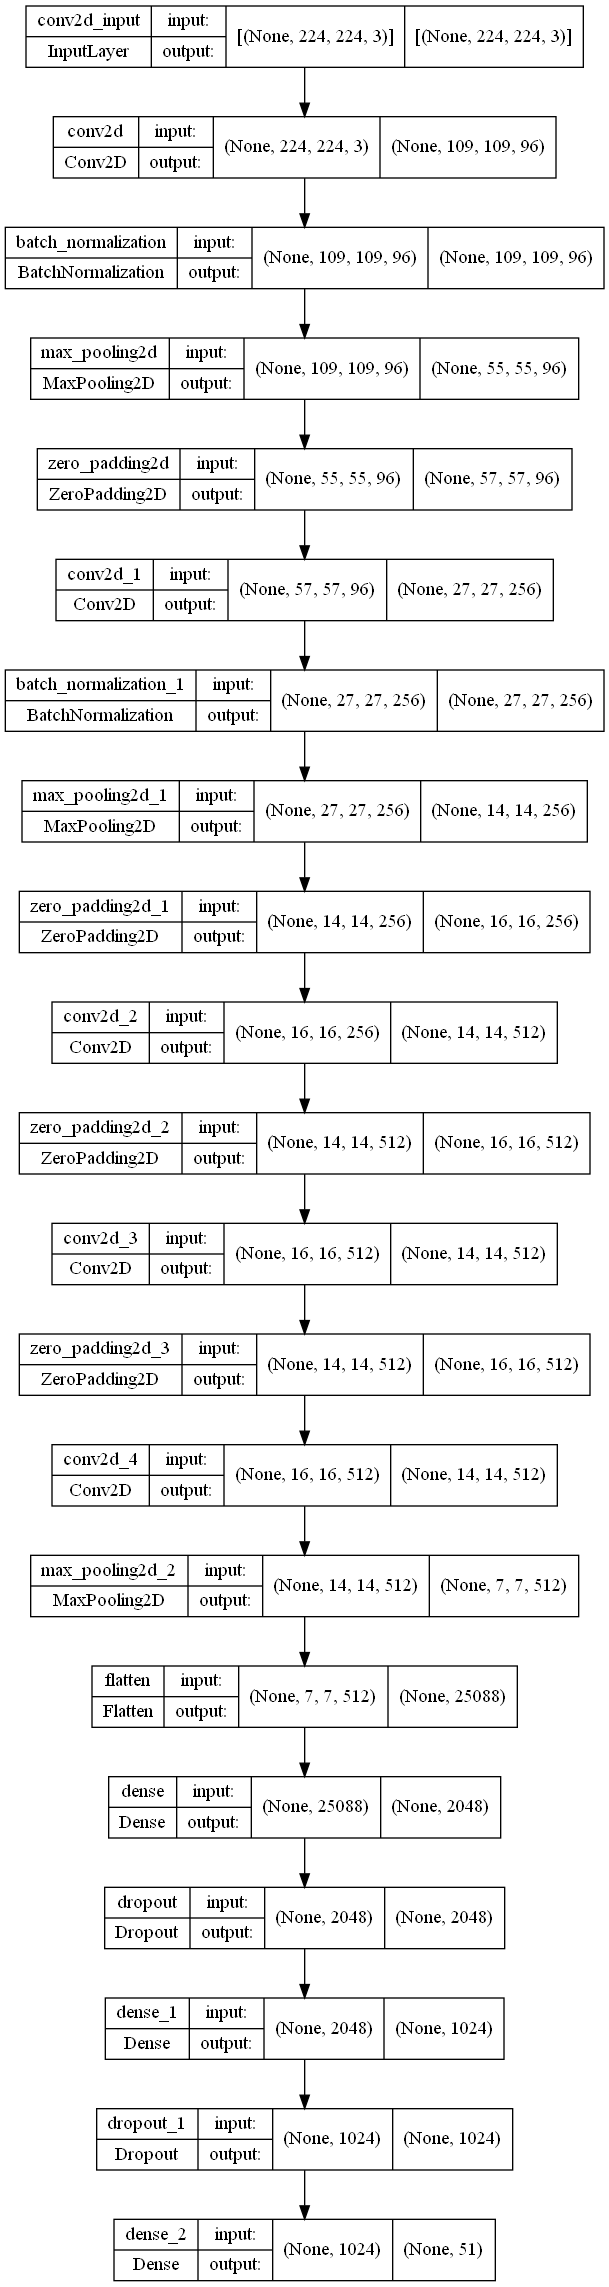

In [14]:
# plot architettura
plot_model(model_spat, to_file=f'./Report/Plots/spatial_stream_CNN/{version}/spatial_stream_schema{version}_{arc}.png', show_shapes=True, show_layer_names=True)

In [15]:
#model_spat.compile(loss=keras.losses.sparse_categorical_crossentropy, metrics=['accuracy','sparse_categorical_accuracy'], 
#              optimizer=keras.optimizers.Adam(learning_rate=0.001))

learning_rate = 1e-3 # -2
momentum = 0.9
#optimizer = keras.optimizers.SGD(learning_rate=learning_rate, momentum=momentum, nesterov=True)
optimizer = Adam(learning_rate=learning_rate)

model_spat.compile(loss=keras.losses.sparse_categorical_crossentropy, 
                   metrics=['sparse_categorical_accuracy','sparse_top_k_categorical_accuracy'], 
                   optimizer=optimizer)

In [16]:
step_per_epoch_train = frame_number_train // batch_size
step_per_epoch_val = frame_number_val // batch_size
print(step_per_epoch_train)
print(step_per_epoch_val)



474
203


In [17]:
history_cnn_spatial_stream = model_spat.fit(train_ds, 
                                            validation_data = val_ds, 
                                            validation_steps=step_per_epoch_val, 
                                            batch_size=batch_size, 
                                            epochs=epochs, 
                                            steps_per_epoch=step_per_epoch_train, 
                                            callbacks=[model_checkpoint_callback, early_stopper])

Epoch 1/150
474/474 [==============================] - 551s 1s/step - loss: 3.6655 - sparse_categorical_accuracy: 0.0758 - sparse_top_k_categorical_accuracy: 0.2704 - val_loss: 3.6816 - val_sparse_categorical_accuracy: 0.0767 - val_sparse_top_k_categorical_accuracy: 0.2597
Epoch 2/150
474/474 [==============================] - 1112s 2s/step - loss: 3.1673 - sparse_categorical_accuracy: 0.1707 - sparse_top_k_categorical_accuracy: 0.4462 - val_loss: 3.7146 - val_sparse_categorical_accuracy: 0.0952 - val_sparse_top_k_categorical_accuracy: 0.3171
Epoch 3/150
474/474 [==============================] - 1025s 2s/step - loss: 2.7839 - sparse_categorical_accuracy: 0.2619 - sparse_top_k_categorical_accuracy: 0.5614 - val_loss: 3.9881 - val_sparse_categorical_accuracy: 0.0946 - val_sparse_top_k_categorical_accuracy: 0.2891
Epoch 4/150
474/474 [==============================] - 1032s 2s/step - loss: 2.4619 - sparse_categorical_accuracy: 0.3410 - sparse_top_k_categorical_accuracy: 0.6418 - val_loss

KeyboardInterrupt: 

In [18]:
score = model_spat.evaluate(val_ds, verbose=1, batch_size = batch_size, steps=step_per_epoch_val)
print('Loss val:', score[0])
print('Sparse_categorical_accuracy:', score[1])

KeyboardInterrupt: 

### History e grafici

In [ ]:
np.save(f'./Models/spatial_stream_CNN/{version}/spatial_stream_CNN_{version}_{arc}_epoch{epochs}_batch{batch_size}_optSDG_{learning_rate}_{momentum}.npy',
        history_cnn_spatial_stream.history)
#history=np.load('my_history.npy',allow_pickle='TRUE').item()

In [ ]:
print(history_cnn_spatial_stream.history.keys())

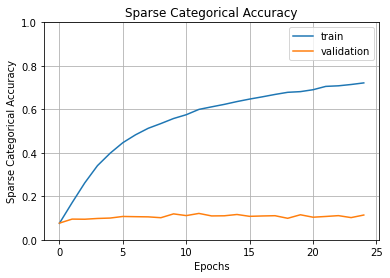

In [21]:
fig1 = plt.gcf()
sparse_categorical_accuracy = [0.0758, 0.1707, 0.2619, 0.3410, 0.3982, 0.4466, 0.4828, 0.5128, 0.5346, 0.5578, 0.5752, 0.5997, 0.6114, 0.6228, 0.6357, 0.6472, 0.6575, 0.6685, 0.6783, 0.6814, 0.6902, 0.7055, 0.7082, 0.7142, 0.7216]
val_sparse_categorical_accuracy = [0.0767, 0.0952, 0.0946, 0.0981, 0.1000, 0.1073, 0.1063, 0.1055, 0.1016, 0.1192, 0.1113, 0.1213, 0.1098, 0.1104, 0.1164, 0.1079, 0.1096, 0.1108, 0.0989, 0.1151, 0.1039, 0.1073, 0.1111, 0.1021, 0.1139]
plt.plot(sparse_categorical_accuracy)
plt.plot(val_sparse_categorical_accuracy)
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Sparse Categorical Accuracy')
metric_plot = 'Accuracy'
plt.ylabel('Sparse Categorical Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig(f'./Report/Plots/spatial_stream_CNN/{version}/spatial_stream_CNN_{version}_{arc}_epoch{epochs}_batch{batch_size}_optSDG_{learning_rate}_{momentum}_metric{metric_plot}.png')
plt.show()

In [ ]:
fig1 = plt.gcf()
plt.plot(history_cnn_spatial_stream.history['sparse_top_k_categorical_accuracy'])
plt.plot(history_cnn_spatial_stream.history['val_sparse_top_k_categorical_accuracy'])
plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Sparse Top 5 Categorical Accuracy')
metric_plot = 'Top 5 Categorical_accuracy'
plt.ylabel('Sparse Top 5 Categorical Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig(f'./Report/Plots/spatial_stream_CNN/{version}/spatial_stream_CNN_{version}_{arc}_epoch{epochs}_batch{batch_size}_optSDG_{learning_rate}_{momentum}_metric{metric_plot}.png')
plt.show()

In [ ]:
fig1 = plt.gcf()
plt.plot(history_cnn_spatial_stream.history['loss'])
plt.plot(history_cnn_spatial_stream.history['val_loss'])
#plt.axis(ymin=0,ymax=1)
plt.grid()
plt.title('Loss (sparse categorical crossentropy)')
metric_plot = 'loss'
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.savefig(f'./Report/Plots/spatial_stream_CNN/{version}/spatial_stream_CNN_{version}_{arc}_epoch{epochs}_batch{batch_size}_optSDG_{learning_rate}_{momentum}_metric{metric_plot}_train.png')
plt.show()

In [ ]:
pd.DataFrame(history_cnn_spatial_stream.history).plot(figsize=(8,5))
plt.show()

In [ ]:
model_spat.save(f'./Models/spatial_stream_CNN/{version}/spatial_stream_CNN_{version}_{arc}_epoch{epochs}_batch{batch_size}_optSDG_{learning_rate}_{momentum}.h5')
# model_mot.save_weights('./Models/model_mot_weights.h5')

### Modello Migliore Evaluation

In [19]:
best_model_motion = keras.models.load_model(f'./Models/spatial_stream_CNN/{version}/spatial_model_{version}_{arc}_val_acc_best.hdf5')

In [22]:
score = best_model_motion.evaluate(val_ds, verbose=1, batch_size = batch_size, steps=step_per_epoch_val)

203/203 [==============================] - 257s 1s/step - loss: 4.7343 - sparse_categorical_accuracy: 0.1213 - sparse_top_k_categorical_accuracy: 0.3440
